# Building a Possum Regression and Classification Model
*By Stephen FitzSimon*

In [1]:
# Data Science libraries
import pandas as pd
import geopandas as gpd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Custom modules
import acquire
import univariate_explore
import prepare
import explore_target_sex
import model_target_sex
import explore_target_age
import model_target_age



## Contents <a name='contents'></a>

1. <a href='#introduction'>Introduction</a>
2. <a href='#acquire'>Acquire the Data</a>
3. <a href='#univariate_explore'>Explore the Univariate Data</a>
    1. <a href='#distributions'>Distributions of Measurements</a>
    2. <a href='#outliers'>Outliers in the Data </a>
    2. <a href='#ear_length'>Boxplot of the `ear_length` measurement </a>
4. <a href='#split'>Splitting the Data </a>
4. <a href='#var_sex'>Target Variable: Sex</a>
    1. <a href='#comparing_stats'>Comparing Measurement Columns' Statistics Between Males and Females</a>
    2. <a href='#anatomical_ratios'>Comparing Ratios of Measurements Between Males and Females</a>
    3. <a href='#body_length'>Exploring the body length calculated measurement</a>
    4. <a href='#body_length_ratio'>Exploring the body in relation to other measurements </a>
    5. <a href='#model_sex'>Making a classification model for sex</a>
5. <a href='#target_age'>Target Variable: Age </a>
5. <a href='#conclusion'>Conclusion</a>

<figure>
<img src='https://upload.wikimedia.org/wikipedia/commons/e/e9/Trichosurus_caninus_Gould.jpg'></img>
<figcaption>Image from wikipedia</figcaption>
</figure>

## Introduction <a name='introduction'></a>

1. <a href='#sources'>Sources</a>
2. <a href='#about_data'>About The Data</a>

The Short-eared possum (*Trichosurus caninus*) is a native Australian possum found along the East coast of the continent.  The following data was collected in 1995 by Lindenmayer; at this point in time it was classified with the cloesly related <a href='https://en.wikipedia.org/wiki/Mountain_brushtail_possum'>Mountain Brushtail Possum (*Trichosurus cunninghami*)</a>.  As a member of the Trichosurus tribe, they are considered more at home on the ground than other members of the Phalangeridae family, yet they remain predominately leaf eaters.

The goal of this project is to explore the anatomical characteristics of the species and develop a linear regression model to predict an individual's age, and a classification model to predict an individual's sex. 

#### More Information On The Species and The Phalangeridae Family

- <a href='https://en.wikipedia.org/wiki/Short-eared_possum'>Species information on Wikipedia</a>

- <a href='https://en.wikipedia.org/wiki/Mountain_brushtail_possum'>Wikipedia informaton on the closely related Mountain brushtail possum</a> (note: before 2002 the two species were thought to be a single species)

- <a href='https://en.wikipedia.org/wiki/Phalangeridae'>Wikipedia information on the Phalangeridae family</a>

- <a href='https://www.theage.com.au/national/a-tail-of-two-possums-20041203-gdz4bq.html'>A tail of two possums - The Age (Melbourne)</a>

- <a href='https://www.iucnredlist.org/species/40557/21951945'>Conservation information at Red List</a>

- <a href='https://www.departments.bucknell.edu/biology/resources/msw3/browse.asp?s=y&id=11000086'>Entry at Mammal Species of the World</a>

- <a href='https://www.youtube.com/watch?v=Cwg2rTorJWc'>Video by Brave Wilderness on the Related Bushtail Possum</a>

### Sources <a name='sources'></a>

*Original Paper*

Lindenmayer DB , Viggers KL , Cunningham RB Donnelly CF (1995) Morphological Variation Among Populations of the Mountain Brushtail Possum, Trichosurus-Caninus Ogilby (Phalangeridae, Marsupialia). *Australian Journal of Zoology* 43, 449-458. https://doi.org/10.1071/ZO9950449

*Kaggle Dataset*

https://www.kaggle.com/datasets/abrambeyer/openintro-possum

*Australia Bureau of Statistics Digital Boundary Files*

https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

### About the Data <a name='#about_data'></a>

*Note: original column names can be found on the kaggle page for the data.  The column names made in the `acquire.py` module are used for the data dictionary.  The information to clean up the data can be found either in the original paper by Lindenmayer or from the documentation on the <a href='https://cran.r-project.org/web/packages/DAAG/index.html'>DAAG dataset on CRAN</a>*

- `case` : observation/identification number of individual
- `trap_site` : the id number of the site where the individual was trapped; they are as follows:
    - Cambarville, Victoria
    - Bellbird, Victoria
    - Whian Whian State Forest, NSW
    - Byrangery Reserve, NSW
    - Conondale Ranges, Queensland
    - Bulburin State Forest, Queensland
    - Allyn River Forest Park, NSW
- `state` : the Australian state of the `trap_site` location 
- `sex` : the sex of the individual
- `age` : the age of the individual in years, determined by tooth wear (Lindenmayer)
- `head_length` : length of the head from the nose tip to the external occipital protuberance in mm
- `skull_width` : the width of the skull at the widest part in mm
- `total_length` : length of the body from the nose tip to the tain end in mm
- `tail_length` : length from tail base to tail tip in mm
- `foot_length` : length from heel to longest toe's tip in mm
- `ear_length` : length from the base of the ear to the tip of the ear
- `eye_width` : the width of the eye from medial to lateral canthus
- `chest_girth` : girth behind the forelimbs in mm
- `belly_girth` : girth behind the last rib in mm
- `latitude`
- `longitude`
- `elevation` : height above sea level in meters

<a href='#contents'>Back to Contents</a>

## Acquire The Data <a name='acquire'></a>

- Columns are renamed to be more user friendly.
- `trap_site`, `state`, `latitude`, `longitude` and `elevation` are added based off of Lindenmayer and DAAG documentation.
- `total_length`, `tail_length`, `chest_girth`, and `belly_girth` are all converted from centimeters to millimeters.
- Three total rows are dropped because of missing data.  Two did not include data in  `sex` which is a target column.
- `latitude`, `longitude` and `elevation` are added with information from Lindenmayer and DAAG data set on CRAN.
- Final dataframe is 101 rows and 17 columns

This section uses the `acquire.py` module to make and prepare the dataset after it is downloaded.  It uses the following functions:

- `make_dataset()` : A flow control function that loads the dataset from the `possum.csv` file and calls the module's other functions to prepare the data set.
- `get_dataset()` : Reads the `possum.csv` and returns it as a dataframe.  If no file is present, an error is printed to the user informating them that they need to download the data from Kaggle.
- `rename_columns()` : Renames the columns so that they are more human readable names
- `map_trap_site_names()` : Maps trap site name numeric ids to strings based on Lindenmayer and DAAG documentation
- `map_state_names()` : Adds the state names based on the trap site information
- `convert_centimeters()` : Converts centimeter columns into millimeter units
- `make_geo_columns()` : Populates the `latitude`, `longitude` and `elevation` columns based on Lindenmayer and DAAG documentation

In [2]:
df = acquire.make_dataset() #make the dataframe
df.sample(3) #display a random three rows of data

,case,trap_site,state,sex,age,head_length,skull_width,total_length,tail_length,foot_length,ear_length,eye_width,chest_girth,belly_girth,latitude,longitude,elevation
102,103,Allyn River Forest Park,New South Wales,male,4.0,91.5,55.2,825.0,365.0,62.9,45.9,15.4,250.0,290.0,-32.116667,151.466667,300
100,101,Allyn River Forest Park,New South Wales,male,1.0,88.6,54.7,825.0,390.0,64.4,48.0,14.0,250.0,330.0,-32.116667,151.466667,300
29,30,Cambarville,Victoria,female,2.0,92.1,54.4,840.0,335.0,70.6,50.8,14.5,245.0,330.0,-37.550000,145.883300,800


In [3]:
df.info() #dataframe info on type and shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 103
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case          101 non-null    int64  
 1   trap_site     101 non-null    object 
 2   state         101 non-null    object 
 3   sex           101 non-null    object 
 4   age           101 non-null    float64
 5   head_length   101 non-null    float64
 6   skull_width   101 non-null    float64
 7   total_length  101 non-null    float64
 8   tail_length   101 non-null    float64
 9   foot_length   101 non-null    float64
 10  ear_length    101 non-null    float64
 11  eye_width     101 non-null    float64
 12  chest_girth   101 non-null    float64
 13  belly_girth   101 non-null    float64
 14  latitude      101 non-null    float64
 15  longitude     101 non-null    float64
 16  elevation     101 non-null    int64  
dtypes: float64(12), int64(2), object(3)
memory usage: 14.2+ KB


<a href='#contents'>Back to Contents</a>

## Explore the Univariate Data <a name='univariate_explore'></a>

1. <a href='#distributions'>Distributions of Measurements</a>
2. <a href='#outliers'>Outliers in the Data </a>
2. <a href='#ear_length'>Boxplot of the `ear_length` measurement </a>

- Plotting all the measurements on histograms shows that all are approximately normally distributed
    - One possible exception is `ear_length` which has two peaks.
- Plotting `ear_length` as a box plot shows that the bottom half of the data is more concentrated than the top half of the data
- There are outliers based on the IQR in the following columns: `total_length`, `tail_length`, `head_length`, `skull_width`, `eye_width`, `chest_girth`, and `belly_girth`

This section uses the `univariate_explore` module.  The following functions are used:
- `make_hist_distributions()` : Creates histograms of the measurement data in 3 x 3 subplots.
- `make_boxplot_outliers()` : Creates boxplots of the measurement data in 3 x 3 subplots.
- `get_outliers_df()` : Creates a dataframe containing the total number of outliers, and the numbers of upper and lower outliers.  It also calls the following function:
    - `get_outlier_bounds()` : Calculates the lower and upper bounds of outliers based on the IQR rule.

### Distributions of Measurements <a name='distributions'></a>

Below is a histograph of all the measurement columns.  They appear largely normally distributed, aside from `ear_length`.  This column is explored more below.

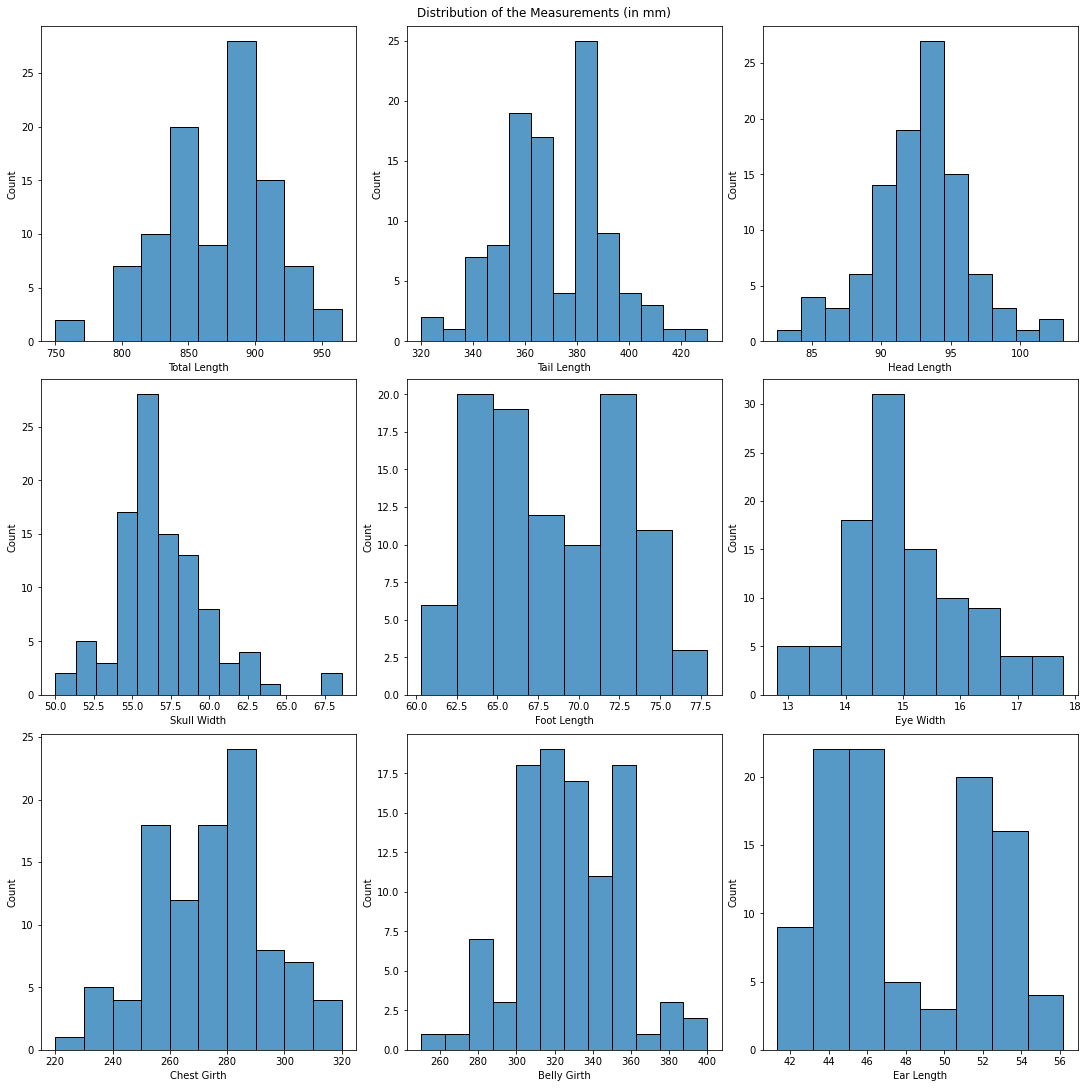

In [4]:
univariate_explore.make_hist_distributions(df)

Back to: <a href='#contents'>Contents</a>   -   <a href='univariate_explore'>Section Contents</a>

### Outliers in the Data <a name='outliers'></a>

Based on the IQR rule, there are some outliers in the data.  Particularly, the outliers in head length, skull width and tail length may be noteworthy in determining the age/sex.

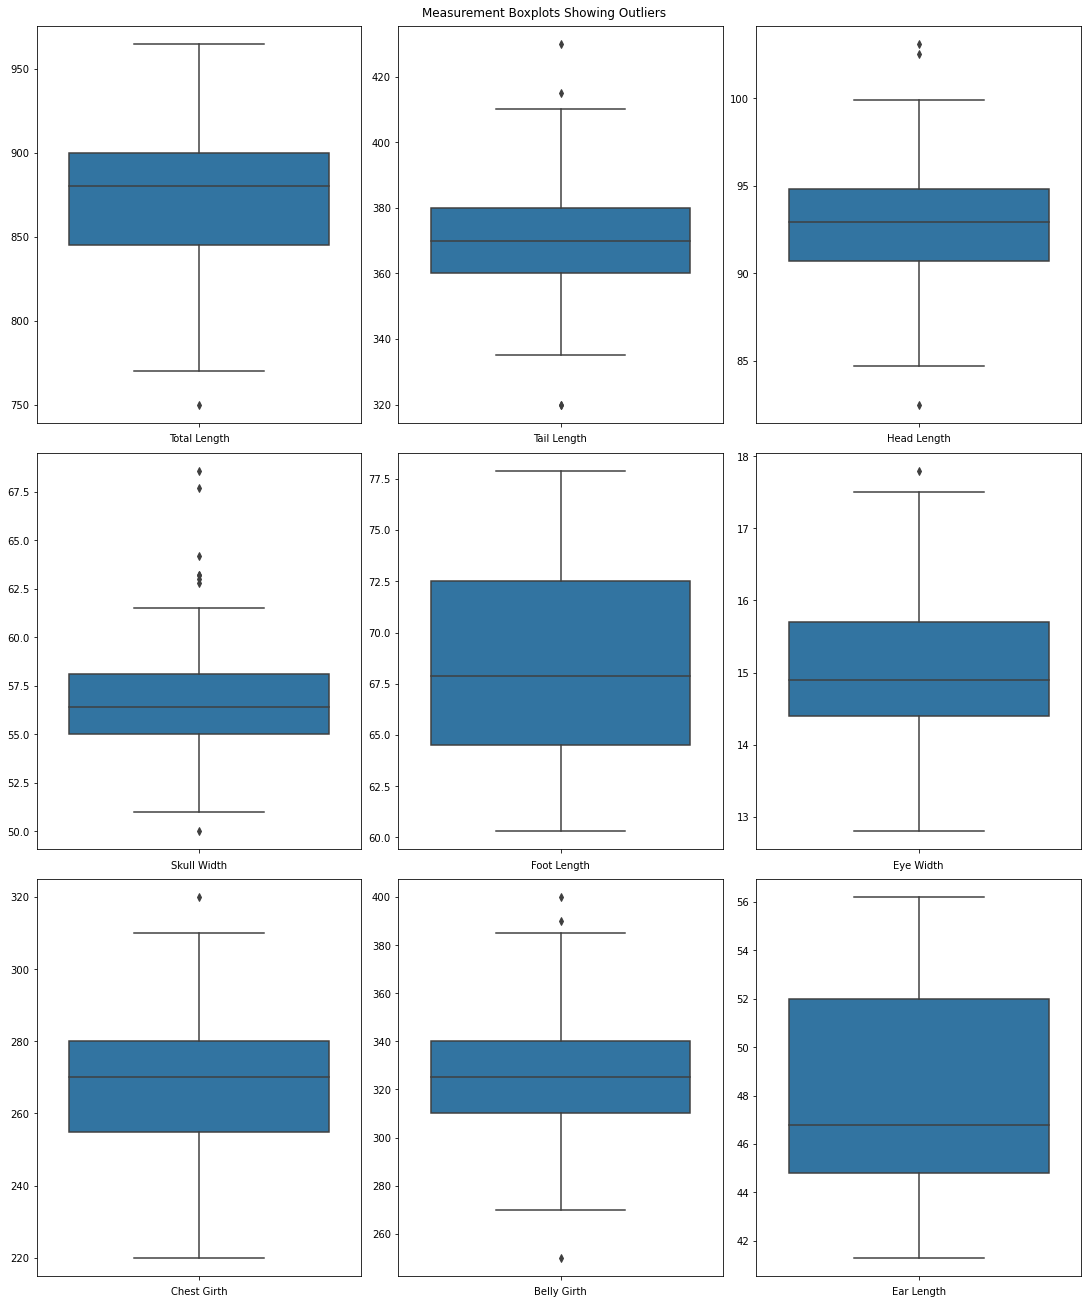

In [5]:
#make a box plot for each measurement
univariate_explore.make_boxplot_outliers(df)

In [6]:
# same data but numeric
univariate_explore.get_outliers_df(df).set_index('column_name').T

column_name,total_length,tail_length,head_length,skull_width,foot_length,eye_width,chest_girth,belly_girth,ear_length
total_outliers,1,4,3,8,0,1,1,3,0
lower_outliers,1,2,1,1,0,0,0,1,0
upper_outliers,0,2,2,7,0,1,1,2,0


Back to: <a href='#contents'>Contents</a>   -   <a href='univariate_explore'>Section Contents</a>

### Boxplot of the `ear_length` measurement <a name='ear_length'></a>

The two halves of the data are distributed across different ranges.  The bottom half of the data has a much smaller range than the upper half.

Lower half range: $\text{median} - \text{minimum} = 46.8 - 41.3 = 5.5$

Upper half range: $\text{maximum} - \text{median} = 56.2 - 46.8 = 9.4$

Text(0.5, 1.0, 'Boxplot of Ear Length')

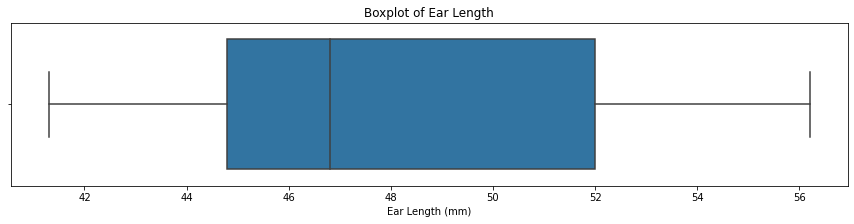

In [7]:
# plot the data as a boxplot
plt.figure(figsize = (15, 3)) #set figure size
sns.boxplot(data=df, x = 'ear_length') #make plot
plt.xlabel("Ear Length (mm)")
plt.title('Boxplot of Ear Length') #title plot

In [8]:
# numeric information
pd.DataFrame(df['ear_length'].describe()).T

,count,mean,std,min,25%,50%,75%,max
ear_length,101.0,48.133663,4.060352,41.3,44.8,46.8,52.0,56.2


Back to: <a href='#contents'>Contents</a>   -   <a href='univariate_explore'>Section Contents</a>

## Splitting the Data <a name='split'></a>

In order to prepare for multivaraite data exploration, the data is split.  70 records are retained for `train`, and 35 records for each `validate` and `test`.  The data is also stratified on the `sex` column to ensure that males and females are evenly distributed among the subsets of the data.

In [9]:
#split the data and confirm the shapes
train, validate, test = prepare.split_data(df)
print(f"Train shape {train.shape}\nValidate shape {validate.shape}\nTest shape {test.shape}")

Train shape (70, 17)
Validate shape (35, 17)
Test shape (35, 17)


In [10]:
# show the proportion of males and females in the sets
prepare.make_sex_distribution_df(train, validate, test).set_index('dataset')

,proportion_male,proportion_female,total_male,total_female
dataset,,,,
train,0.585714,0.414286,41,29
validate,0.571429,0.428571,20,15
test,0.600000,0.400000,21,14


<a href='#contents'>Back to Contents</a>

## Target Variable: Sex <a name='var_sex'></a>

1. <a href='#comparing_stats'>Comparing Measurement Columns' Statistics Between Males and Females</a>
2. <a href='#anatomical_ratios'>Comparing Ratios of Measurements Between Males and Females</a>
3. <a href='#body_length_ratio'>Exploring the Ratio Between Body Measurements and Head Measurements </a>
4. <a href='#model_sex'>Making a classification model for sex </a>

### Comparing Measurement Columns' Statistics Between Males and Females <a name='comparing_stats'></a>

- The measurements do not seem to differ much between males and females. The most any measurement differs between median/average males and females is 35 mm, and the majority of measures differ by less than 10 mm
    - This is confirmed by hypothesis testing with a confidence level of 0.95.
- The measurements differed more in the spread as can be seen in the box plots.  For example:
    - `total_length`, `foot_length`, `chest_girth` and `ear_length` : about half of females were longer than 75% of males
- This confirms the findings of Lindenmayer (452) which found no difference in the measurements between males and females
   
Below is a table of the number of records for each sex.

In [11]:
train.groupby('sex')[['case']].count().T

sex,female,male
case,29,41


#### Visualizations

Below is a box plot that shows the difference between the medians and spreads between males and females for each anatomical measurement.

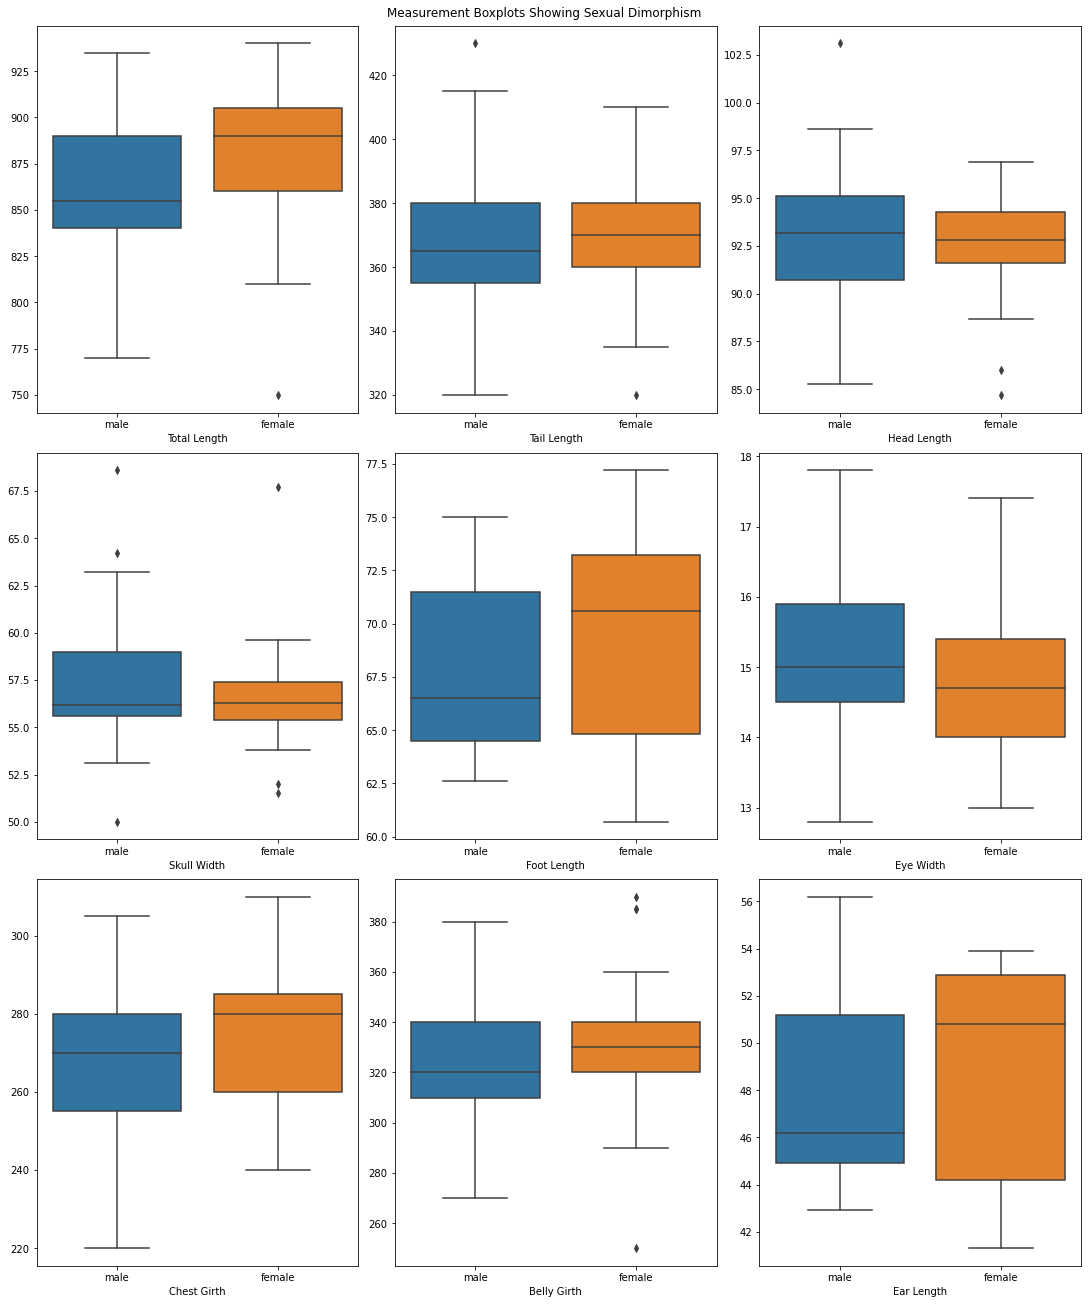

In [12]:
explore_target_sex.make_boxplot_sex_outliers(train)

Below shows a pointplot showing the difference in the mean between males and females for each measurement.  Note that the confidence interval (the vertical lines passing through each dot) largely overlap the same range of values. 

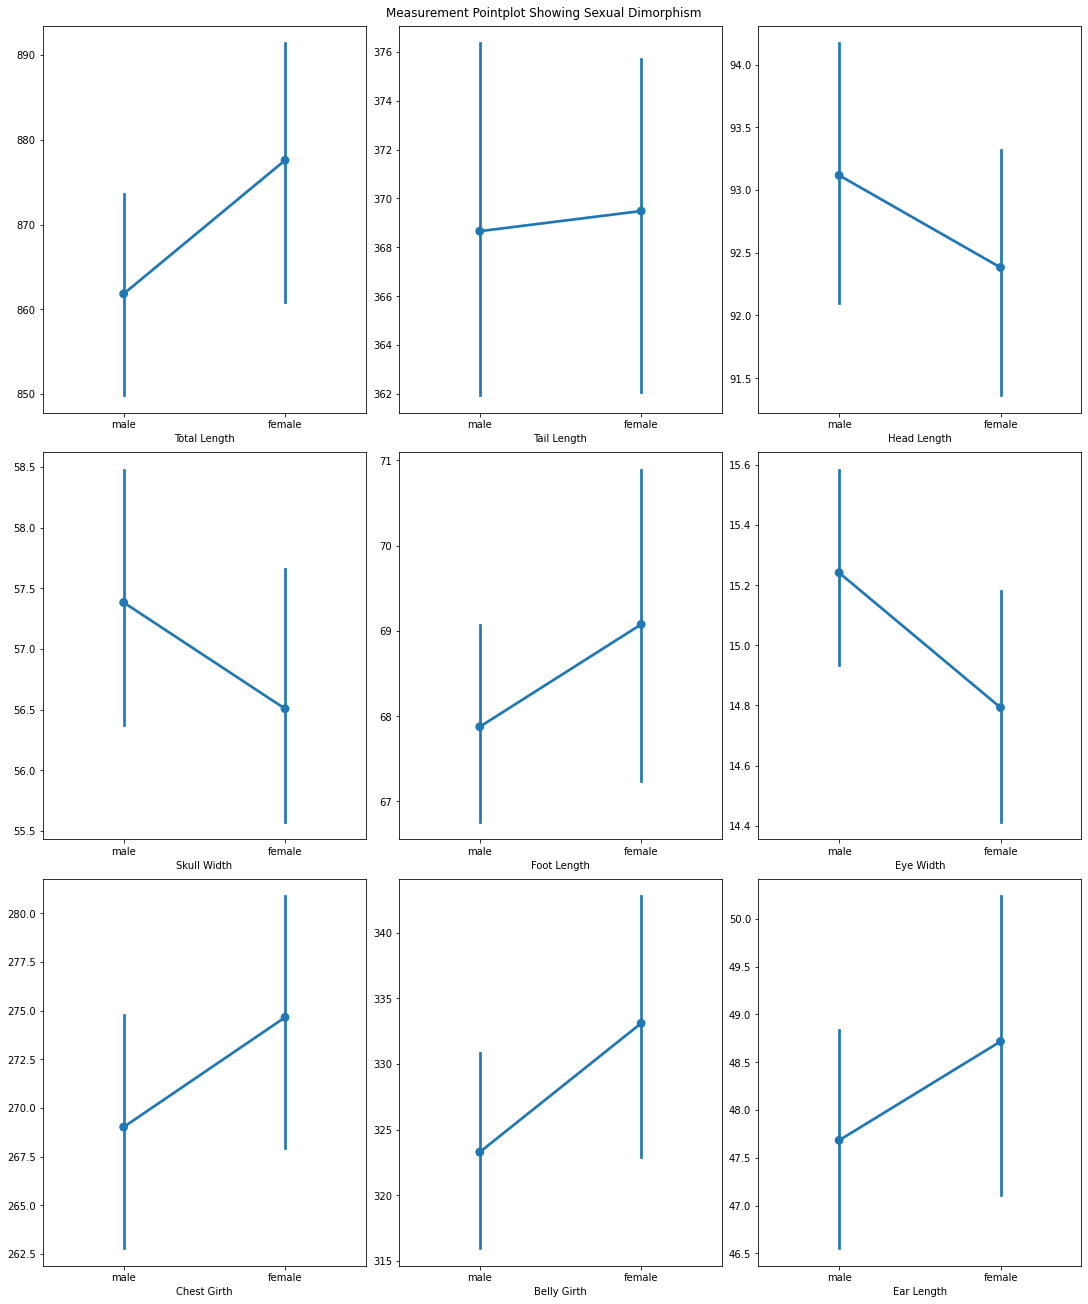

In [13]:
explore_target_sex.make_pointplot(train)

The below histograms also show that the measurements' distributions largely overlap.

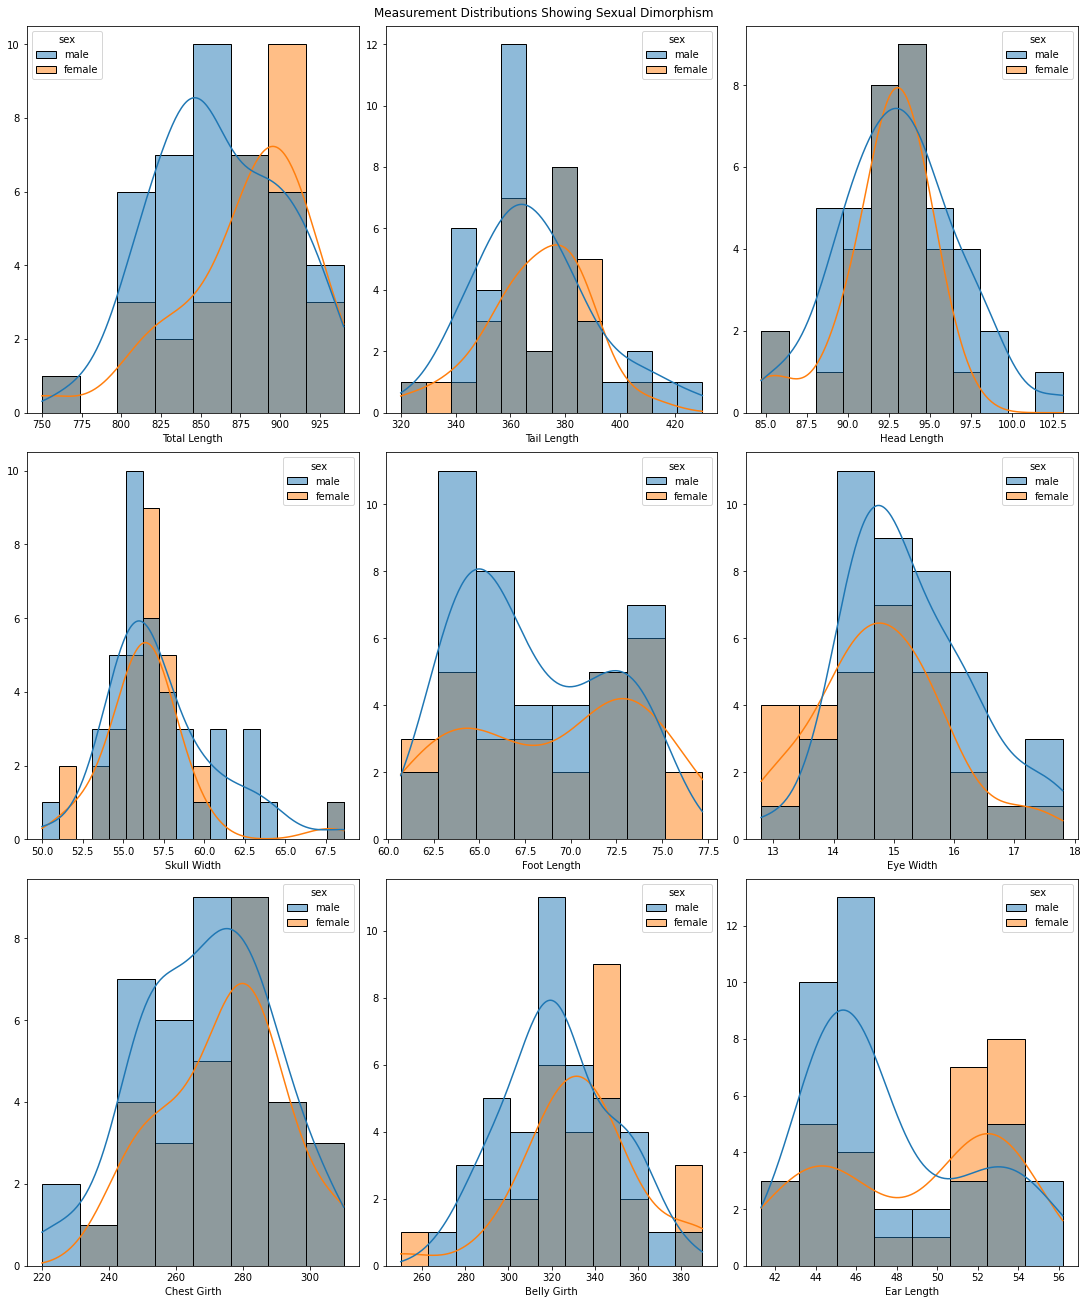

In [14]:
explore_target_sex.make_histograms_by_sex(train)

The following table shows the numeric information represented on the boxplot and pointplot.

In [15]:
explore_target_sex.compare_stats(train).set_index('column_name')

,male_mean,female_mean,difference_mean,male_median,female_median,difference_median,male_std,female_std
column_name,,,,,,,,
total_length,861.829268,877.586207,15.756939,855.0,890.0,35.0,40.043041,41.974071
tail_length,368.658537,369.482759,0.824222,365.0,370.0,5.0,22.528437,18.914508
head_length,93.117073,92.382759,0.734315,93.2,92.8,0.4,3.572597,2.668208
skull_width,57.382927,56.506897,0.876030,56.2,56.3,0.1,3.465321,2.826650
foot_length,67.875610,69.075862,1.200252,66.5,70.6,4.1,3.977297,4.973405
eye_width,15.241463,14.793103,0.448360,15.0,14.7,0.3,1.067702,1.082963
chest_girth,269.024390,274.655172,5.630782,270.0,280.0,10.0,19.500625,18.221408
belly_girth,323.292683,333.103448,9.810765,320.0,330.0,10.0,25.189526,28.642307
ear_length,47.682927,48.717241,1.034315,46.2,50.8,4.6,3.902749,4.416614


Below are the selected statistics for several columns showing how, for some measurements, about half of the females are greater than about three fourths of the males.

In [16]:
train[['sex', 'total_length', 'foot_length']].groupby('sex').describe()

total_length                                                            \
              count        mean        std    min    25%    50%    75%    max   
sex                                                                             
female         29.0  877.586207  41.974071  750.0  860.0  890.0  905.0  940.0   
male           41.0  861.829268  40.043041  770.0  840.0  855.0  890.0  935.0   

       foot_length                                                     
             count       mean       std   min   25%   50%   75%   max  
sex                                                                    
female        29.0  69.075862  4.973405  60.7  64.8  70.6  73.2  77.2  
male          41.0  67.875610  3.977297  62.6  64.5  66.5  71.5  75.0

In [17]:
train[['ear_length', 'chest_girth', 'sex']].groupby('sex').describe()

ear_length                                                     \
            count       mean       std   min   25%   50%   75%   max   
sex                                                                    
female       29.0  48.717241  4.416614  41.3  44.2  50.8  52.9  53.9   
male         41.0  47.682927  3.902749  42.9  44.9  46.2  51.2  56.2   

       chest_girth                                                            
             count        mean        std    min    25%    50%    75%    max  
sex                                                                           
female        29.0  274.655172  18.221408  240.0  260.0  280.0  285.0  310.0  
male          41.0  269.024390  19.500625  220.0  255.0  270.0  280.0  305.0

### Hypothesis Testing

Note that from the above histogram graphs it is clear that the columns are normally distributed; in addition, the number of individuals for each sex are greater than 30.  Therefore, a t-test can be used to compare the means.

The following hypotheses are tested with an α of 0.05:

$H_0$ : The mean x among males is equal to the mean x among females.

$H_a$ : The mean x among males is not equal to the mean x among females.

Where x is a measurement.

In [18]:
explore_target_sex.hypothesis_two_sample_ttest(train).set_index('column_name')

,t-stat,p-value,reject_null
column_name,,,
total_length,-1.589754,0.116529,False
tail_length,-0.160874,0.872669,False
head_length,0.936669,0.352244,False
skull_width,1.122049,0.265788,False
foot_length,-1.120488,0.266448,False
eye_width,1.720519,0.089886,False
chest_girth,-1.222406,0.225774,False
belly_girth,-1.516337,0.134069,False
ear_length,-1.034131,0.304739,False


The null hypothesis is likely true with a confidence of 0.95; this means that the measurements are unlikely to differ between males and females.

Back to : <a href='#contents'>Contents</a>   -   <a href='#var_sex'>Section Contents</a>

### Comparing Ratios of Measurements Between Males and Females <a name='anatomical_ratios'></a>

- The ratio between every possible pair of measurements if evaluated for a difference between the males and female individuals
- There appears to be a different in the ratio of the head measurements to the body measurements; for example, the ratio between the `total_length` and the `head_length`, or the ratio between the `chest_girth` and the `skull_width`
    - Some of the measurements that are proxies for head size also show this relation with body size; for example, `eye_width` and `belly_girth` (`eye_width` is a proxy for `skull_width`)
    - This is confirmed with hypothesis testing at a confidence interval of 0.95

#### Visualizations

Below the boxplots show the distributions of the ratio between two measurements and their difference between male and female individuals.

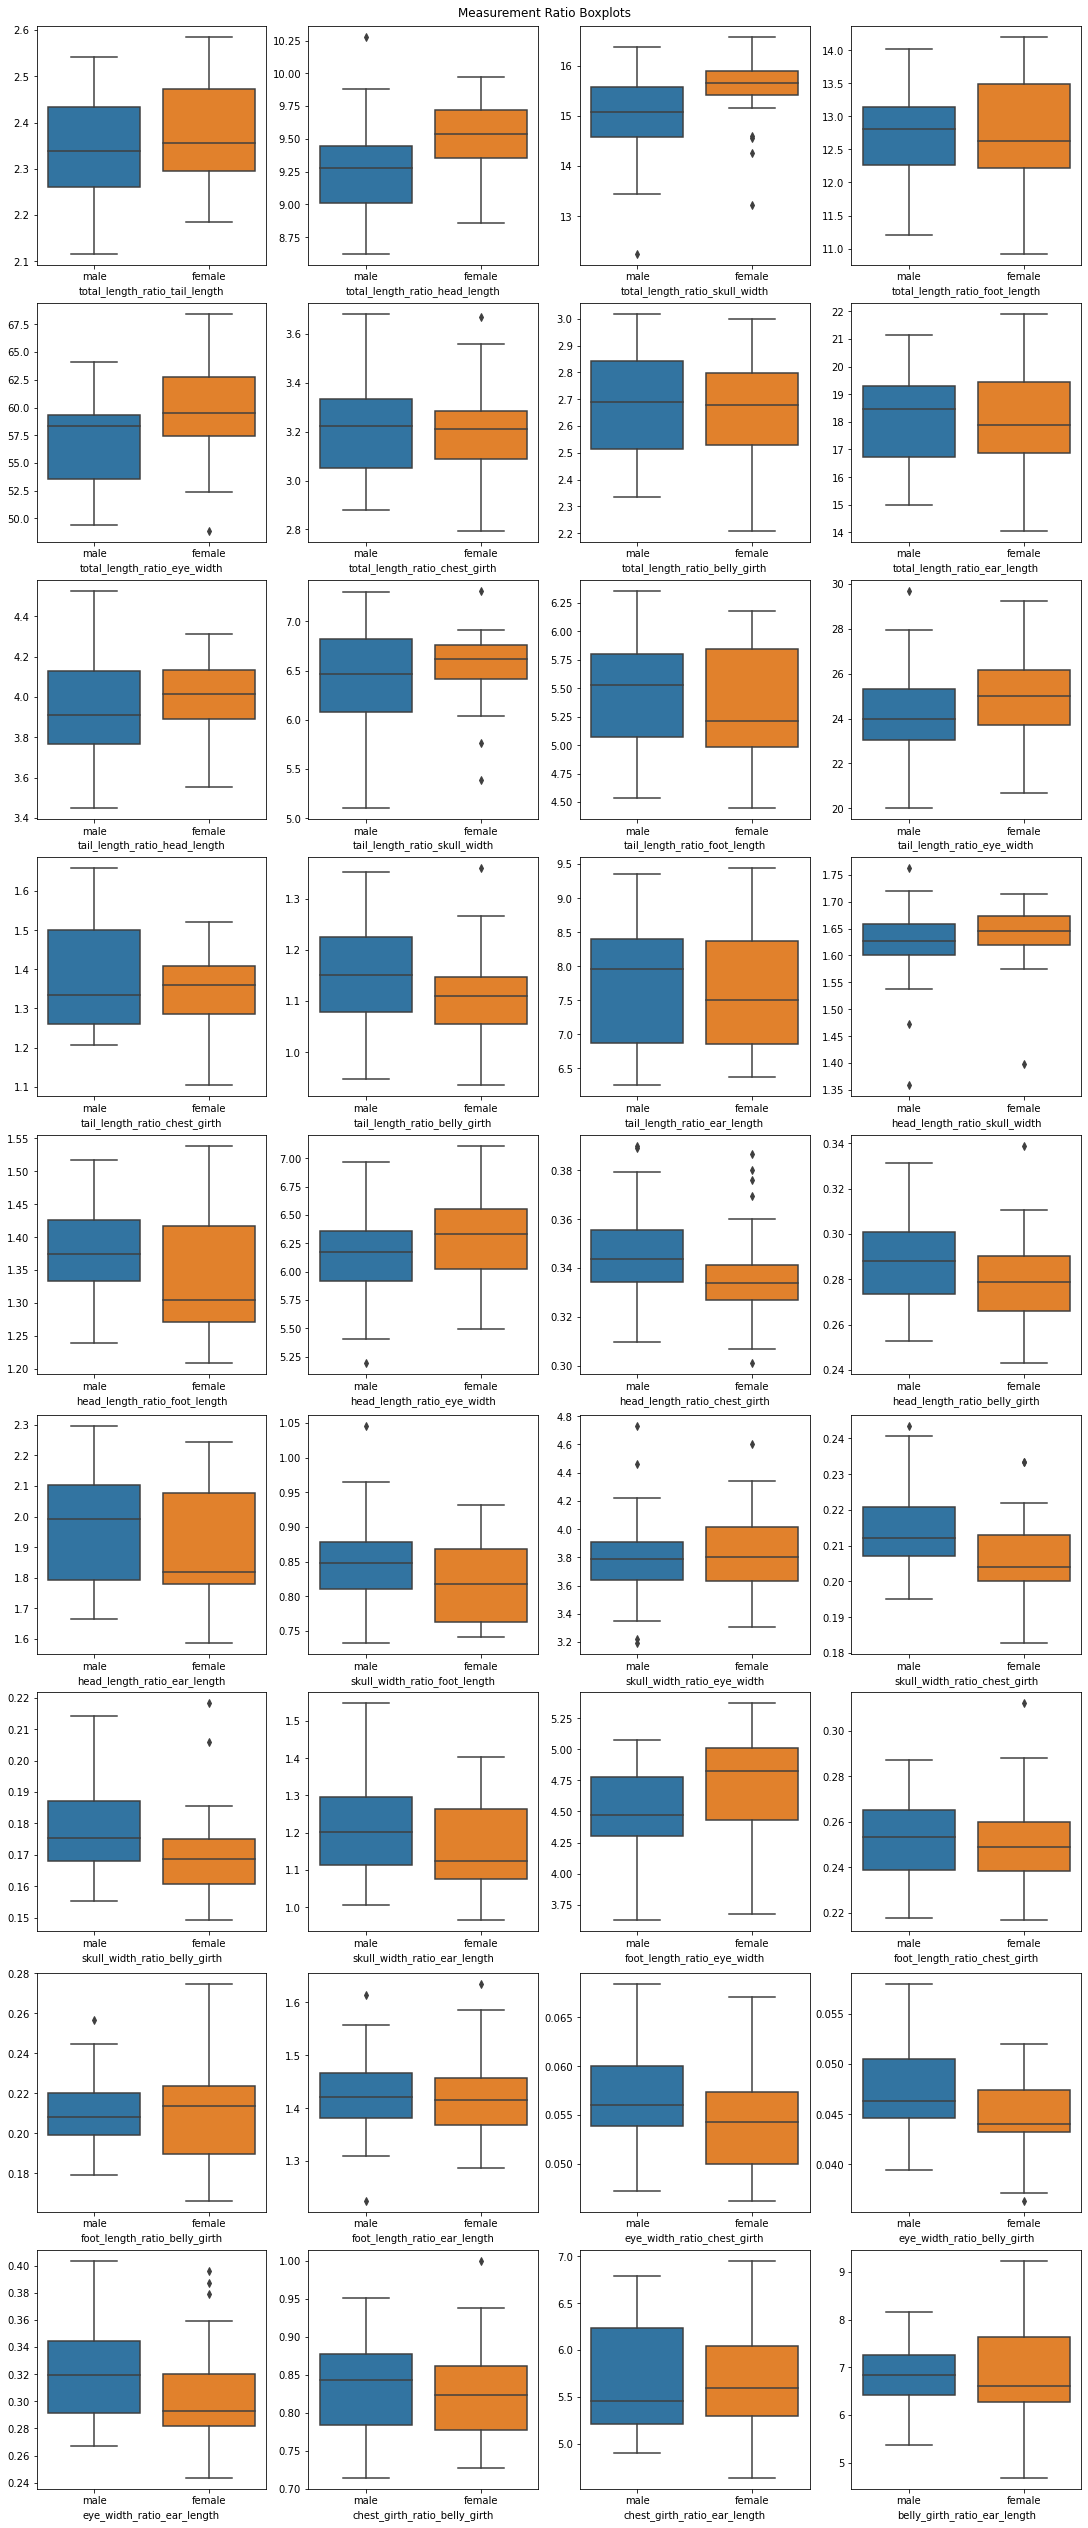

In [19]:
explore_target_sex.make_boxplot_sex_ratios(train)

The scatter graphs below show the scatter plot between all the pairs of measurements.  While from the above boxplots shows that there is a difference in the ratio, the two measurements do not really show any grouping on the x-y plane; however, this might not be the case with higher dimensions.

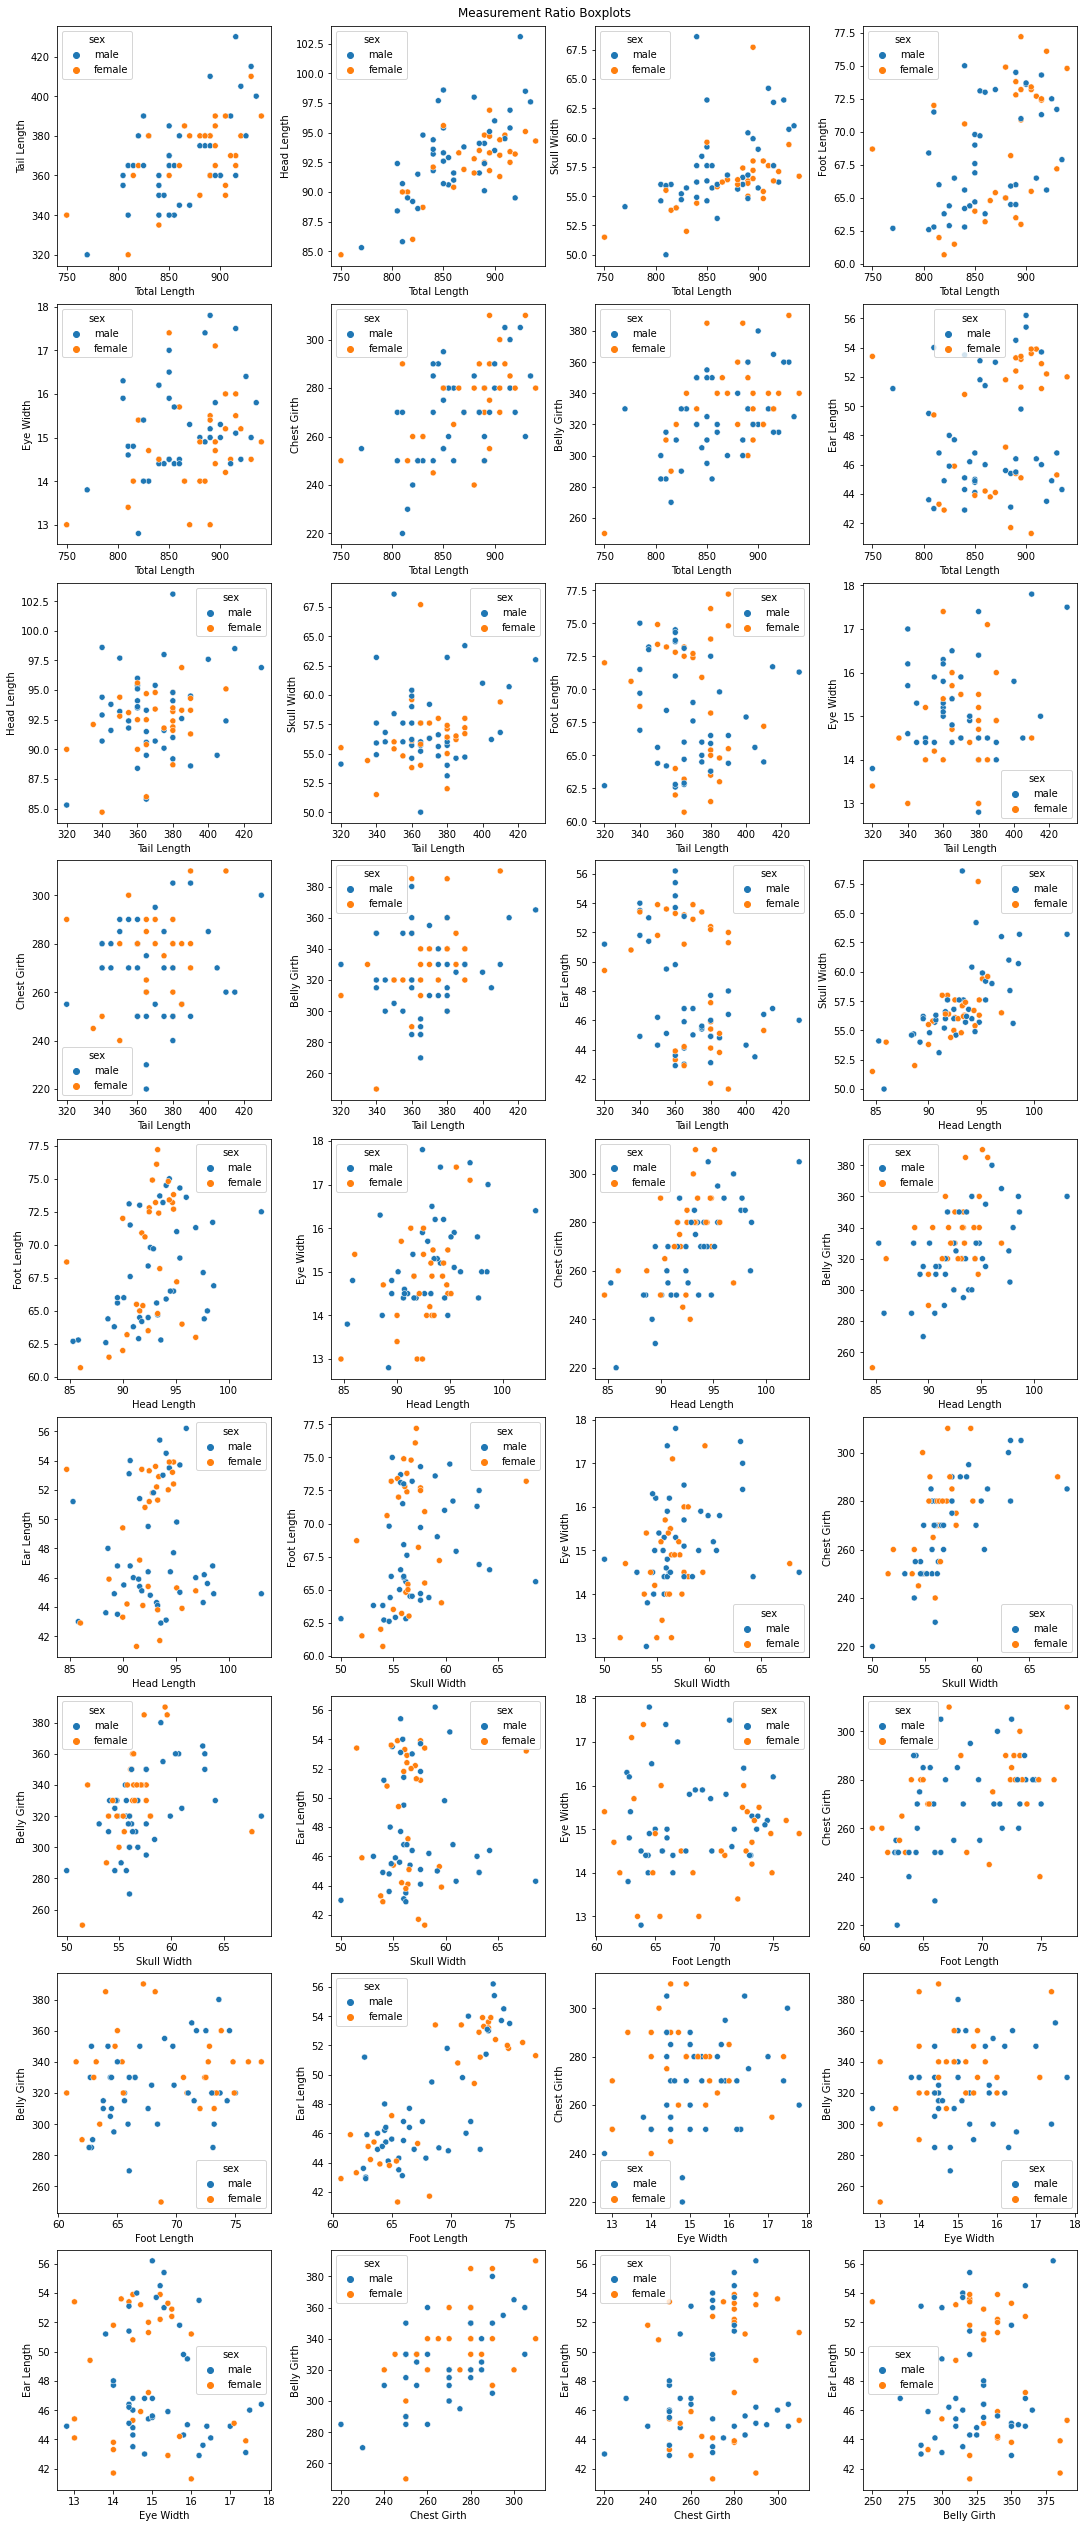

In [20]:
explore_target_sex.make_scatterplot_sex_ratios(train)

#### Hypothesis Testing

The following hypotheses are tested:

$H_0$ : The average ratio between column x and column y for males is equal to the average ratio between column x and column y for females.

$H_a$ : The average ratio between column x and column y for males is not equal to the average ratio between column x and column y for females.

Where column x and column y are given by `column_x_ratio_column_y` in the table below.

In [21]:
explore_target_sex.hypothesis_two_sample_ttest_ratio(train).sort_values(['reject_null', 'p-value'], ascending=False)

,ratio_column,t-stat,p-value,reject_null
18,head_length_ratio_chest_girth,2.033515,0.045905,True
19,head_length_ratio_belly_girth,2.124375,0.037278,True
26,foot_length_ratio_eye_width,-2.214365,0.030159,True
24,skull_width_ratio_belly_girth,2.225926,0.029337,True
30,eye_width_ratio_chest_girth,2.338317,0.022319,True
31,eye_width_ratio_belly_girth,2.641924,0.010221,True
23,skull_width_ratio_chest_girth,2.660114,0.009735,True
2,total_length_ratio_skull_width,-2.702329,0.008687,True
4,total_length_ratio_eye_width,-2.840700,0.005934,True
1,total_length_ratio_head_length,-3.008888,0.003675,True


Back to : <a href='#contents'>Contents</a>   -   <a href='#var_sex'>Section Contents</a>

### Exploring the body length calculated measurement <a name='body_length'></a>

- Body length is calculated as: $$ \text{total_length} - (\text{head_length} + \text{tail_length}) $$
- The majority of females have a longer body length than males
    - A statistical test confirms that there is a difference in the calculation between males and females.

In [22]:
body_df = explore_target_sex.make_body_column(train)
body_df.sample(3)

,case,trap_site,state,sex,age,head_length,skull_width,total_length,tail_length,foot_length,ear_length,eye_width,chest_girth,belly_girth,latitude,longitude,elevation,body_length
66,67,Conondale Ranges,Queensland,male,4.0,93.3,57.6,850.0,365.0,64.7,44.1,16.5,275.0,295.0,-26.433333,152.583333,400,391.7
7,8,Cambarville,Victoria,female,6.0,94.8,57.6,910.0,370.0,72.7,53.9,14.5,290.0,340.0,-37.550000,145.883300,800,445.2
86,87,Allyn River Forest Park,New South Wales,male,2.0,98.5,60.7,930.0,415.0,71.7,46.8,15.0,260.0,360.0,-32.116667,151.466667,300,416.5


#### Visualization

Below is the box plot of body length for males and females

Text(0, 0.5, 'Sex')

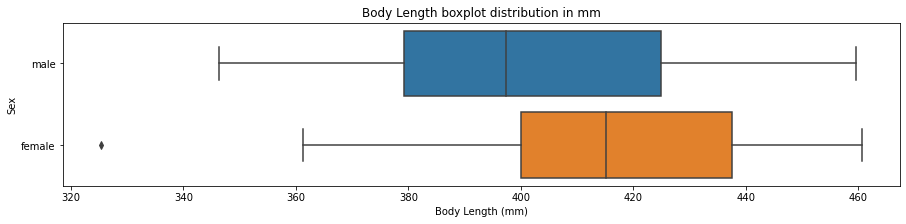

In [23]:
# plot the data as a boxplot
plt.figure(figsize = (15, 3)) #set figure size
sns.boxplot(data = body_df, y='sex', x='body_length') #make the plot
plt.title("Body Length boxplot distribution in mm") #set the title
plt.xlabel('Body Length (mm)') #set the x label
plt.ylabel('Sex') #set the y label

The following shows a historgram showing the distribution of body length measurements.

Text(0.5, 0, 'Body Length (mm)')

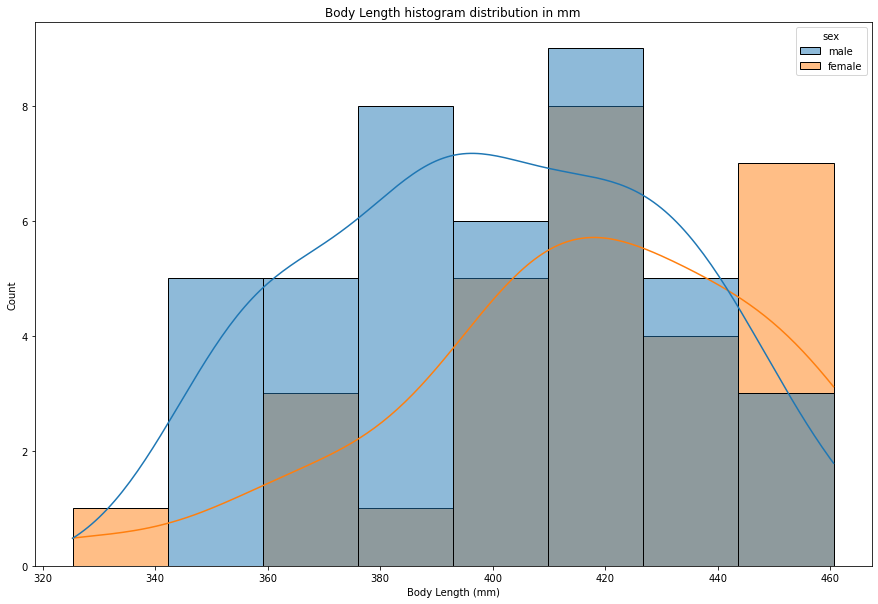

In [24]:
# plot the data as a boxplot
plt.figure(figsize = (15, 10)) #set figure size
#make the plot
sns.histplot(data=body_df, x ='body_length', hue='sex', kde=True)
plt.title("Body Length histogram distribution in mm") #set the title
plt.xlabel('Body Length (mm)') #set the x label

In [25]:
#same data but numeric
body_df.groupby('sex')['body_length'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,29.0,415.720690,32.610213,325.3,400.0,415.2,437.5,460.6
male,41.0,400.053659,30.527357,346.4,379.3,397.3,424.9,459.6


#### Hypothesis Testing

The following hypothesis is tested with $α = 0.05$:

$H_0$ : The mean body length of males is equal to the mean body length of females.

$H_a$ : The mean body length of males is not equal to the mean body length of females.

In [26]:
explore_target_sex.single_two_sample_ttest(body_df, 'body_length').set_index('column_name')

,t-stat,p-value,reject_null
column_name,,,
body_length,-2.056245,0.0436,True


The null hypothesis is rejected; therefore, it is likely that there is a difference in the body length between males and females.

Back to : <a href='#contents'>Contents</a>   -   <a href='#var_sex'>Section Contents</a>

### Exploring the body in relation to other measurements <a name='body_length_ratio'></a>

- Consider the ratio between the `body_length` and one of `head_length`, `eye_width` and `skull_width`.  Visually on the boxplots they appear to be different between males and females.
    - This difference is confirmed by hypothesis testing.
    
    
Make columns to calculate the ratio between the measurements for each individual

In [27]:
#make three ratio columns:
body_df = explore_target_sex.make_ratio_columns(train)

#### Visualization

The boxplots below show the relation between the `body length` and `head_length`, `eye_width` and `skull_width`.

Text(0.5, 0.98, 'Boxplots of body length in relation to other measurements')

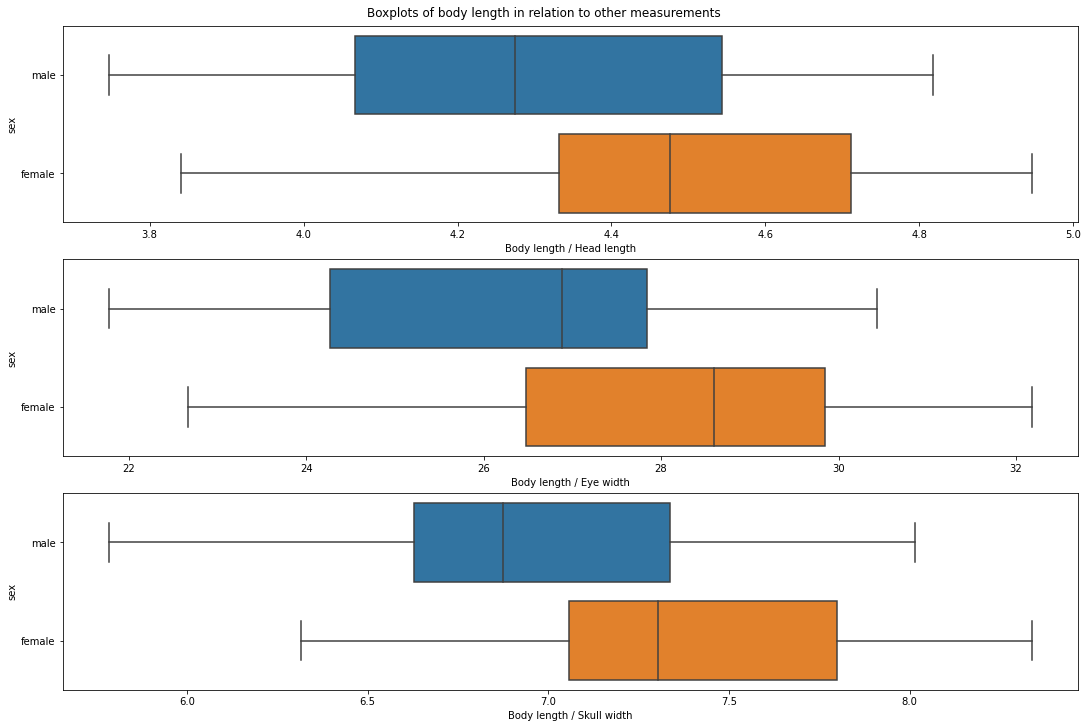

In [28]:
#make figure to hold subplots
fig, axes = plt.subplots(3,1, figsize = (15,10), constrained_layout=True)

#make subplots on figure with labels
sns.boxplot(data=body_df, y = 'sex', x = 'body_head_ratio', ax = axes[0])
axes[0].set_xlabel('Body length / Head length')
sns.boxplot(data=body_df, y = 'sex', x = 'body_eye_ratio', ax = axes[1])
axes[1].set_xlabel('Body length / Eye width')
sns.boxplot(data=body_df, y = 'sex', x = 'body_skull_ratio', ax = axes[2])
axes[2].set_xlabel('Body length / Skull width')

#title the plot
fig.suptitle('Boxplots of body length in relation to other measurements')

#### Hypothesis testing

All hypothesis testing is done using $\alpha = 0.05$.

1. 

$H_0$ : The mean ratio between the body length and the head length is equal among males and females

$H_a$ : The mean ratio between the body length and the head length is not equal among males and females

In [29]:
explore_target_sex.single_two_sample_ttest(body_df, 'body_head_ratio').set_index('column_name')

,t-stat,p-value,reject_null
column_name,,,
body_head_ratio,-2.973747,0.004068,True


The null hypothesis is likely false.  The ratio is different among males and females. 

2. 

$H_0$ : The mean ratio between the body length and the eye width is equal among males and females

$H_a$ : The mean ratio between the body length and the eye width is not equal among males and females

In [30]:
explore_target_sex.single_two_sample_ttest(body_df, 'body_eye_ratio').set_index('column_name')

,t-stat,p-value,reject_null
column_name,,,
body_eye_ratio,-3.179143,0.002224,True


The null hypothesis is likely false.  The ratio is different among males and females

3. 

$H_0$ : The mean ratio between the body length and the skull width is equal among males and females

$H_a$ : The mean ratio between the body length and the skull width is not equal among males and females

In [31]:
explore_target_sex.single_two_sample_ttest(body_df, 'body_skull_ratio').set_index('column_name')

,t-stat,p-value,reject_null
column_name,,,
body_skull_ratio,-3.057647,0.003188,True


The null hypothesis is likely false.  The ratio is different among males and females

Back to : <a href='#contents'>Contents</a>   -   <a href='#var_sex'>Section Contents</a>

### Making a classification model for sex <a name='model_sex'></a>

Three strategies of modeling are used: the first using all the measurement columns, the second using a combination of the measurement columns and calculated ratios, and third using calculated ratio columns.  The following columns are calculated to model on:
- `body_length` as calculated above
- `body_head_ratio` : the ratio of `body_length` to `head_length`
- `body_eye_ratio` : the ratio of `body_length` to `eye_width`
- `body_skull_ratio` : the ratio of `body_length` to `skull_width`
- `total_head_ratio` : the ratio of `total_length` to `head_length`
- `total_eye_ratio` : the ratio of `total_length`to `eye_width`
- `total_skull_ratio` : the ratio of `total_length` to `skull_width`
- `belly_head_ratio` : the ratio of `belly_girth` to `head_length`
- `belly_skull_ratio` : the ratio of `belly_girth` to `skull_width`
- `belly_eye_ratio` : the ratio of `belly_girth` to `eye_width`
- `chest_head_ratio` : the ratio of `chest_girth` to `head_length`
- `chest_skull_ratio` : the ratio of `chest_girth` to `head_length`
- `foot_eye_ratio` : the ratio of `foot_length` to `eye_width`

#### Baseline Model

A baseline model is developed that uses the mode of the `sex` column to use as a prediction.

In [32]:
baseline_model = train.loc[:, ['case', 'sex']]
baseline_model['prediction'] = train.sex.mode().to_list()[0]
baseline_model

baseline_model, baseline_accuracy = model_target_sex.make_baseline_model(train, validate)
baseline_model

,model,train_accuracy,validate_accuracy
0,Baseline Model,0.585714,0.571429


#### Train and Validate Model Predictions

- Measurements and ratios are passed to the model as a z-score
- Note that the `modeling_strategy` column has the following values:
    - `measurement_only` : model is only passed measurement columns from original dataframe
    - `ratio_only` : model is only passed ratio columns as calculated above
    - `measurement_ratio` : model is passed boht the measurement columns and the the calculated ratio columns
- `accuracy_change` : calculated as the difference between `train_accuracy` and `validate_accuracy`

The below table shows the accuracy for the train and validate datasets for each model.  The Radius Neighbors Classification with both the measurement data and the ratio data performs the best for both train and validate sets.  This indicats grouping in the data; that is, the n-sphere centered on any given record contains points that are categorized similarly.  The Support Vector Classification also performs well with all three combinations of datapoints; however, with the combination of the measurement and ratio data leading to possible slight overfitting.  Speculating based off of the algorithm, the hyperplane calculated from the measurement and ratio may have a wider margin around the plane, whereas this is not true for the measurement and ratio data alone.  This is basically only speculation for both algorithms, without actually calculating the points' relation to the plane or the density of the points  (in the case of the Radius Neighbors classifier).

In [33]:
model_df = model_target_sex.model_maker(train, validate, baseline_accuracy)
model_df.set_index('model').sort_values(['validate_accuracy', 'accuracy_change'], ascending=False)

,train_accuracy,validate_accuracy,accuracy_change,better_than_baseline,modeling_strategy
model,,,,,
Radius Neighbors Classification,0.957143,0.942857,0.014286,True,measurement_ratio
Support Vector Classification,0.842857,0.771429,0.071429,True,measurement_ratio
Support Vector Classification,0.814286,0.771429,0.042857,True,measurement_only
Support Vector Classification,0.814286,0.771429,0.042857,True,ratio_only
Radius Neighbors Classification,0.814286,0.771429,0.042857,True,ratio_only
K-Nearest Neighbors Classification,0.814286,0.742857,0.071429,True,ratio_only
Logistic Regression,0.785714,0.714286,0.071429,True,measurement_ratio
Logistic Regression,0.771429,0.685714,0.085714,True,measurement_only
K-Nearest Neighbors Classification,0.771429,0.685714,0.085714,True,measurement_ratio


#### Final Model Testing

- The Radius Neighbors Classification model is used with both the measurement and ratio data.
- The final accuracy of the model is 0.97

The table below shows the change in accuracy across data subsets.

In [34]:
test_model_df, model_predictions = model_target_sex.test_model(train, validate, test, baseline_accuracy)
test_model_df.set_index('model')

,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline
model,,,,
Radius Neighbors Classification,0.957143,0.942857,0.971429,True


The table below shows a selection of the predictions for the test dataset, along with the probability of the prediction.

In [35]:
model_predictions.set_index('case').sample(15).T

case,74,47,70,85,28,100,6,30,2,49,99,103,92,76,57
sex,female,male,female,male,male,male,female,female,female,male,female,male,male,male,female
predicted,female,male,female,male,male,male,female,female,female,male,female,male,male,male,female
probability_male,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.25,1.0,0.0,1.0,1.0,1.0,0.0
probability_female,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.75,0.0,1.0,0.0,0.0,0.0,1.0


#### Model discussion

The model is remarkably accurate across all three data subsets.  There are two predictions that do not have a probability of 1.0.  Most likely this accuracy is a product of the small sample of the data in the total dataset.  I would expect the model to be less accurate when applied to the actual population of possums.

Back to : <a href='#contents'>Contents</a>   -   <a href='#var_sex'>Section Contents</a>

## Target Variable: Age <a name='target_age'></a>

1. <a href='#age_measurements'>Finding A Correlation Between Age and Measurements</a>
2. <a href='#model_age'>Building a Regression Model To Predict Possum Age </a>

*Start with a new dataframe.  The same acquire and prepare functions are called, so the data selection remains the same; only the feature engineered columns are gone*

In [36]:
df = acquire.make_dataset() #make the dataframe
#split the data and confirm the shapes
train, validate, test = prepare.split_data(df)
print(f"Train shape {train.shape}\nValidate shape {validate.shape}\nTest shape {test.shape}")

Train shape (70, 17)
Validate shape (35, 17)
Test shape (35, 17)


### Finding A Correlation Between Age and Measurements <a name='age_measurements'></a>

- `head_length`, `total_length`, `belly_girth`, and `chest_girth` are all correlated with `age`
    - `belly_girth` and `chest_girth` have a stronger relationship with age than with the other measurements.

#### Visualizations

Below are graphs showing the linear regression line between age and the anatomical measurement columns.  It appears that body girth measurements (`chest_girth` and `belly_girth`) are possibly the best predictors of the age of a possum.  In addition `head_length` and `total_length` are positively correlated.  It is interesting to note that these four categories also had some outliers, which might be changing the correlation strength.

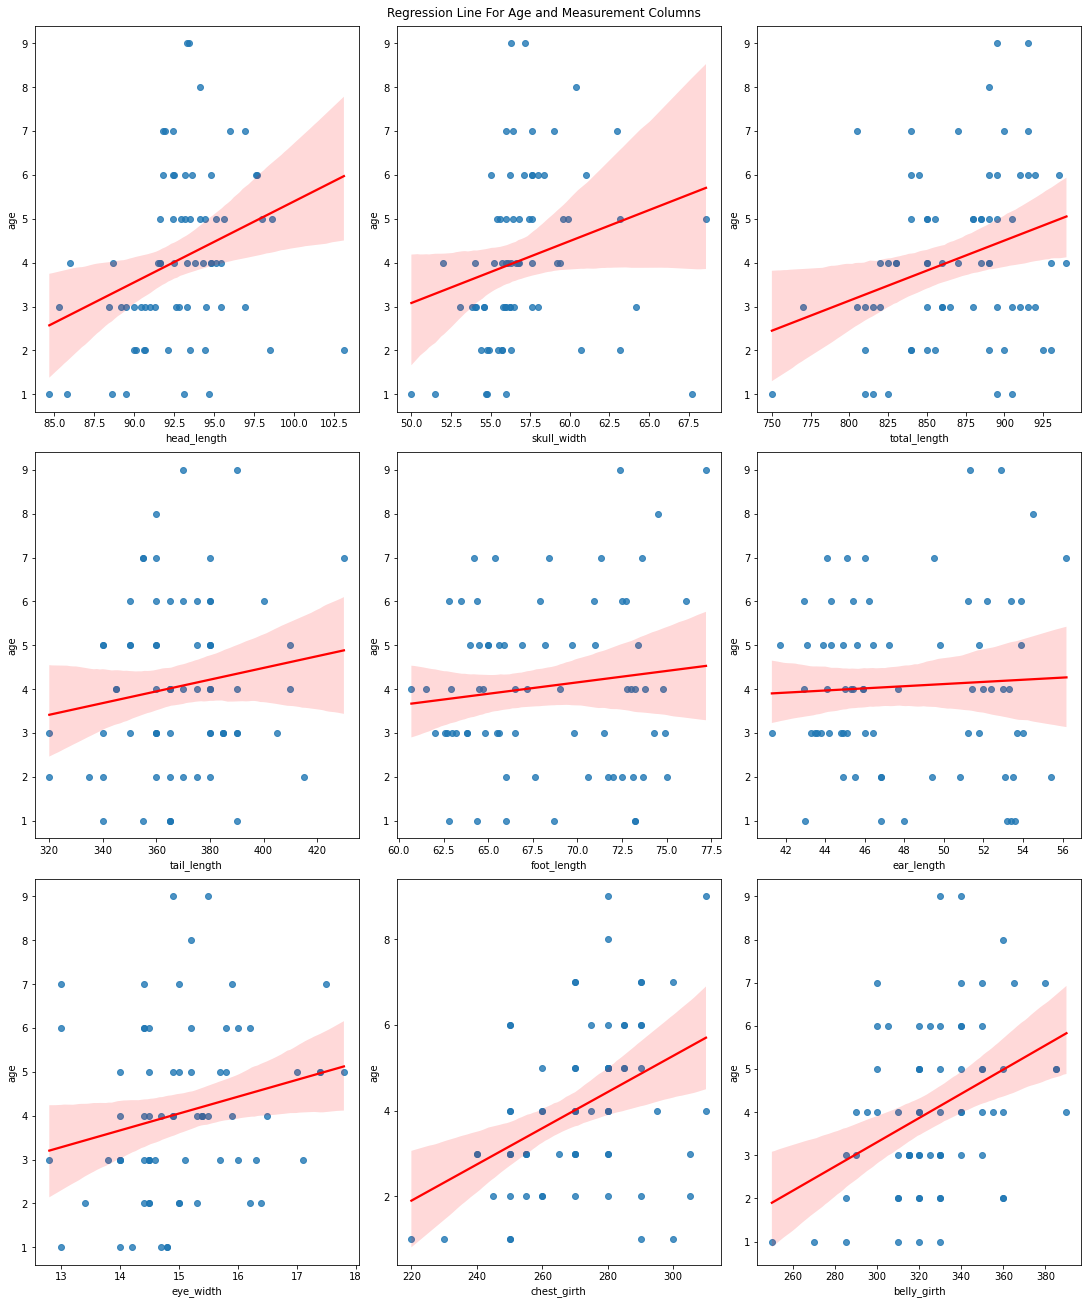

In [37]:
explore_target_age.make_correlation_plots(train)

#### Hypothesis Testing 

The following hypotheses are tested:

$H_0$ : Age and column $x$ are not correlated

$H_a$ : Age and column $x$ are correlated

Where $x$ is one of the measurement columns.

In [38]:
explore_target_age.correlation_test(train).sort_values(['reject_null', 'r_value'], ascending = False)

,x_column,y_column,r_value,p_value,reject_null
7,chest_girth,age,0.415770,0.000344,True
8,belly_girth,age,0.390256,0.000838,True
0,head_length,age,0.308259,0.009426,True
2,total_length,age,0.292401,0.014038,True
1,skull_width,age,0.234986,0.050212,False
6,eye_width,age,0.215953,0.072572,False
3,tail_length,age,0.144600,0.232354,False
4,foot_length,age,0.119040,0.326337,False
5,ear_length,age,0.052170,0.667985,False


The null hypothesis is likely false for `head_length`, `total_length`, `chest_girth`, and `belly_girth`.  This means that these columns are likely correlated with the age.  This makes intuitive sense: older possum grow longer and gain weight (in this case, `belly_girth` and `chest_girth` are proxy for weight).  Note that, as was clear from the scatter plots, the `belly_girth` and `chest_girth` had a fairly strong correlation, whereas `head_length` and `total_length` were less strong correlations.

Back to : <a href='#contents'>Contents</a>   -   <a href='#target_age'>Section Contents</a>

### Building a Regression Model To Predict Possum Age <a name='model_age'></a>

#### Baseline Model <a name='age_baseline'></a>

Two baseline featureless models are created using the mean and the median as the predictions.  RMSE, $R^2$ and explained variance are used as metrics to evaluate all models. Note, these are very poor baseline models.

In [39]:
model_target_age.make_baseline_model(train, validate).set_index('model')

,train_RMSE,train_r2,train_explained_variance,validate_RMSE,validate_r2,validate_explained_variance
model,,,,,,
baseline_mean,1.922212,0.000000,0.0,1.720524,-0.008412,-2.220446e-16
baseline_median,1.923538,-0.001381,0.0,1.715476,-0.002503,-2.220446e-16


### Train and Validate Model Predictions

In [40]:
model_results, train_predictions, validate_predictions = model_target_age.model_maker(train, validate)

In [42]:
model_results.sort_values('validate_RMSE')

,model,train_RMSE,train_r2,train_explained_variance,validate_RMSE,validate_r2,validate_explained_variance,modeling_strategy
5,RadiusNeighborsRegressor,0.423046,0.951563,0.951602,0.514859,0.909699,9.104715e-01,all_columns
9,RadiusNeighborsRegressor,1.430059,0.446516,0.446633,1.264903,0.454957,4.925311e-01,correlated_columns_only
8,KNeighborsRegressor,1.557837,0.343187,0.349870,1.391813,0.340100,3.737486e-01,correlated_columns_only
4,KNeighborsRegressor,1.488432,0.400409,0.400464,1.471637,0.262236,2.809344e-01,all_columns
2,LinearRegression,1.670614,0.244647,0.244647,1.525702,0.207032,2.213597e-01,all_columns
3,TweedieRegressor,1.721692,0.197752,0.197752,1.571672,0.158527,1.714123e-01,all_columns
6,LinearRegression,1.704585,0.213615,0.213615,1.577758,0.151998,1.611655e-01,correlated_columns_only
7,TweedieRegressor,1.732326,0.187812,0.187812,1.578345,0.151366,1.615612e-01,correlated_columns_only
1,baseline_median,1.923538,-0.001381,0.000000,1.715476,-0.002503,-2.220446e-16,NaN
0,baseline_mean,1.922212,0.000000,0.000000,1.720524,-0.008412,-2.220446e-16,NaN
